In [1]:
''' 
SRT2CSV
vsulli
26 April 2025
read in a .srt file 
convert to a df to perform nlp
export to a .csv file for upload to ANKI
'''

import nltk
import numpy as np
import pandas as pd
import pysrt
import re
import seaborn as sns
import spacy
import string

from nltk.corpus import stopwords
german_sw = stopwords.words('german')
from textblob import TextBlob

# allows for displaying multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# keeps full GUI from appearing
Tk().withdraw() 

# shows dialog box to ask for filename
filename = askopenfilename()

''

In [23]:
# specify the encoding if UnicodeDecodeError
# you can open the file in NotePad and check SaveAs for default encoding
# ANSI, UTF-8
subs = pysrt.open(filename, encoding='UTF-8')

In [24]:
def remove_formatting(subfile):
    # read through every sub line
    # using regex, delete section of line between <>
    # combine to string
    # update index
    for i in range(len(subfile)):
        # replace all characters between < and > with ""
        # using regex
        # strip white space from beginning
        subfile[i].text = subfile[i].text.lstrip()
        subfile[i].text = re.sub(r'<c.vtt_\w+>\s*"*', "", subfile[i].text)
        subfile[i].text = re.sub("</c>", "", subfile[i].text)
        # replace "-" with ""
        subfile[i].text = re.sub("-", "", subfile[i].text)

    return subfile

In [25]:
subs = remove_formatting(subs)

In [6]:
# create a dataframe with desired column name - 'Subtitle'
def create_dataframe(subfile, col_name):
    # create dataframe
    df = pd.DataFrame(columns=[col_name])
    for i in range(len(subfile)):
        df.loc[i] = subfile[i].text
    return df

In [45]:
# combine rows until period or end character reached
# append these rows to list and then create new df - more efficient than appending to df
# end characters at index -1 must be ) . ? ! 
df = create_dataframe(subs, 'Subtitle')
df
new_df_list = []
current_row = ""
for row in df['Subtitle']:
    if row[-1] == ")" or row[-1] == "." or row[-1] == "?" or row[-1] == "!":
        current_row += row
        new_df_list.append(current_row)
        current_row = ""
    else:
        current_row += row

# create new df from the list of combined rows
# currently fewer rows - need to verify that it combined the rows correctly
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df


,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...
...,...
752,<font color=#ffffff>Haben Sie Verwandte in der...
753,<font color=#ffffff>Herr Landsberger?</font>\n...
754,<font color=#ffffff>Herr Trimmel'?</font>
755,<font color=#ffffff>Wohl ein Jugendbildnis von...


""


""


In [41]:
# create new dataframe removing the subtitle font tags
# go row by row adding up all the characters from the > tag to the < tag
new_df_list = []
current_row = ""
for row in new_df['Subtitle']:
    # slice between two characters > and < 
    match = re.findall(r'>(.*?)<', row)
    if match:
        new_df_list.append(match[0])
    else:
        new_df_list.append(row)

    
# create new df from the list of combined rows
# currently fewer rows - need to verify that it combined the rows correctly
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df

""


KeyError: 'Subtitle'

In [8]:
# basic exploratory data analysis
df = create_dataframe(subs, 'Subtitle')
df.head()
df.shape
df.dtypes
df.describe(include='all')

,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...


(757, 1)

Subtitle    object
dtype: object

,Subtitle
count,757
unique,745
top,<font color=#ffffff>Danke.</font>
freq,3


In [9]:
# convert to lowercase
def make_lowercase(df):
    df['Lowercase'] = df['Subtitle'].str.lower()
    return df

In [10]:
# remove punctuation
def remove_punctuation(df):
    # starts with any word, digits, or underscore, white space character, + means any character in the string
    df['Lowercase'] = df['Lowercase'].str.replace(r'[^\w\s]+', ' ', regex = True)
    # df['Subtitle'] = df['Subtitle'].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [11]:
# remove newline \n character
def remove_newline(df):
    df['Subtitle'] = df['Subtitle'].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [12]:
df = create_dataframe(subs, 'Subtitle')
clean_df = remove_newline(df)

clean_df = make_lowercase(clean_df)
print(clean_df.head())

                                            Subtitle  \
0                       <font color=#ffffff>.</font>   
1  <font color=#ffffff>(Motor wird angelassen)</f...   
2  <font color=#ffffff>Herr Landsberger?</font> <...   
3  <font color=#ffffff>Motorhaube und Kofferraum ...   
4  <font color=#ffffff>Machen Sie den Koffer auf!...   

                                           Lowercase  
0                       <font color=#ffffff>.</font>  
1  <font color=#ffffff>(motor wird angelassen)</f...  
2  <font color=#ffffff>herr landsberger?</font> <...  
3  <font color=#ffffff>motorhaube und kofferraum ...  
4  <font color=#ffffff>machen sie den koffer auf!...  


In [13]:
clean_df = remove_punctuation(clean_df)
print(clean_df.head())
clean_df[100:101]

                                            Subtitle  \
0                       <font color=#ffffff>.</font>   
1  <font color=#ffffff>(Motor wird angelassen)</f...   
2  <font color=#ffffff>Herr Landsberger?</font> <...   
3  <font color=#ffffff>Motorhaube und Kofferraum ...   
4  <font color=#ffffff>Machen Sie den Koffer auf!...   

                                           Lowercase  
0                            font color ffffff font   
1      font color ffffff motor wird angelassen font   
2   font color ffffff herr landsberger font   fon...  
3   font color ffffff motorhaube und kofferraum ã...  
4   font color ffffff machen sie den koffer auf f...  


,Subtitle,Lowercase
100,<font color=#ffffff>In Leipzig gekauft.</font>...,font color ffffff in leipzig gekauft font f...


In [14]:
df['Word Tokens'] = df['Lowercase'].apply(nltk.word_tokenize)

In [15]:
word_tokens = df['Lowercase'].apply(nltk.word_tokenize)
word_tokens

0                            [font, color, ffffff, font]
1      [font, color, ffffff, motor, wird, angelassen,...
2      [font, color, ffffff, herr, landsberger, font,...
3      [font, color, ffffff, motorhaube, und, kofferr...
4      [font, color, ffffff, machen, sie, den, koffer...
                             ...                        
752    [font, color, ffffff, haben, sie, verwandte, i...
753    [font, color, ffffff, herr, landsberger, font,...
754           [font, color, ffffff, herr, trimmel, font]
755    [font, color, ffffff, wohl, ein, jugendbildnis...
756                          [font, color, ffffff, font]
Name: Lowercase, Length: 757, dtype: object

In [16]:
df['Sentence Tokens'] = df['Lowercase'].apply(nltk.sent_tokenize)

In [17]:
sentence_tokens = df['Lowercase'].apply(nltk.sent_tokenize)
sentence_tokens

0                              [ font color ffffff font]
1        [ font color ffffff motor wird angelassen font]
2      [ font color ffffff herr landsberger font   fo...
3      [ font color ffffff motorhaube und kofferraum ...
4      [ font color ffffff machen sie den koffer auf ...
                             ...                        
752    [ font color ffffff haben sie verwandte in der...
753    [ font color ffffff herr landsberger font   fo...
754               [ font color ffffff herr trimmel font]
755    [ font color ffffff wohl ein jugendbildnis von...
756                            [ font color ffffff font]
Name: Lowercase, Length: 757, dtype: object

In [18]:
# remove stopwords

# have to extend stopwords to include names of characters
custom_stop_words = ['hamburg', 'berlin', 'elise', 'christian', 'berti', 'eva', 'chris']
german_sw.extend(custom_stop_words)

df['no_stop_words'] = df['Word Tokens'].apply(lambda x: [item for item in x if item not in german_sw])
df[100:120]

,Subtitle,Lowercase,Word Tokens,Sentence Tokens,no_stop_words
100,<font color=#ffffff>In Leipzig gekauft.</font>...,font color ffffff in leipzig gekauft font f...,"[font, color, ffffff, in, leipzig, gekauft, fo...",[ font color ffffff in leipzig gekauft font ...,"[font, color, ffffff, leipzig, gekauft, font, ..."
101,<font color=#ffffff>Musst du immer kurze RÃ¶ck...,font color ffffff musst du immer kurze rã cke...,"[font, color, ffffff, musst, du, immer, kurze,...",[ font color ffffff musst du immer kurze rã ck...,"[font, color, ffffff, musst, immer, kurze, rã,..."
102,<font color=#ffffff>Jetzt reicht's.</font> <fo...,font color ffffff jetzt reicht s font font ...,"[font, color, ffffff, jetzt, reicht, s, font, ...",[ font color ffffff jetzt reicht s font font...,"[font, color, ffffff, reicht, s, font, font, c..."
103,<font color=#ffffff>Hast du vor mir noch nie</...,font color ffffff hast du vor mir noch nie fo...,"[font, color, ffffff, hast, du, vor, mir, noch...",[ font color ffffff hast du vor mir noch nie f...,"[font, color, ffffff, hast, nie, font, font, c..."
104,<font color=#ffffff>FÃ¼r wen mache ich das all...,font color ffffff fã¼r wen mache ich das alle...,"[font, color, ffffff, fã¼r, wen, mache, ich, d...",[ font color ffffff fã¼r wen mache ich das all...,"[font, color, ffffff, fã¼r, wen, mache, font]"
105,<font color=#ffffff>FÃ¼r Erich</font> <font co...,font color ffffff fã¼r erich font font colo...,"[font, color, ffffff, fã¼r, erich, font, font,...",[ font color ffffff fã¼r erich font font col...,"[font, color, ffffff, fã¼r, erich, font, font,..."
106,"<font color=#ffffff>FÃ¼r uns beide, dachte ich...",font color ffffff fã¼r uns beide dachte ich ...,"[font, color, ffffff, fã¼r, uns, beide, dachte...",[ font color ffffff fã¼r uns beide dachte ich...,"[font, color, ffffff, fã¼r, beide, dachte, font]"
107,<font color=#ffffff>Da kannst du alleine</font...,font color ffffff da kannst du alleine font ...,"[font, color, ffffff, da, kannst, du, alleine,...",[ font color ffffff da kannst du alleine font ...,"[font, color, ffffff, kannst, alleine, font, f..."
108,<font color=#ffffff>Ich lass mir wegen dem</fo...,font color ffffff ich lass mir wegen dem font...,"[font, color, ffffff, ich, lass, mir, wegen, d...",[ font color ffffff ich lass mir wegen dem fon...,"[font, color, ffffff, lass, wegen, font, font,..."
109,<font color=#ffffff>(TÃ¼r knallt)</font>,font color ffffff tã¼r knallt font,"[font, color, ffffff, tã¼r, knallt, font]",[ font color ffffff tã¼r knallt font],"[font, color, ffffff, tã¼r, knallt, font]"


In [19]:
df[100:101]['Subtitle']
df[0:20]['no_stop_words']

100    <font color=#ffffff>In Leipzig gekauft.</font>...
Name: Subtitle, dtype: object

0                           [font, color, ffffff, font]
1        [font, color, ffffff, motor, angelassen, font]
2     [font, color, ffffff, herr, landsberger, font,...
3     [font, color, ffffff, motorhaube, kofferraum, ...
4                   [font, color, ffffff, koffer, font]
5          [font, color, ffffff, sitzbank, bitte, font]
6          [font, color, ffffff, kind, schlã, ft, font]
7     [font, color, ffffff, auãÿerdem, geht, gut, font]
8            [font, color, ffffff, handschuhfach, font]
9     [font, color, ffffff, danke, font, font, color...
10                [font, color, ffffff, hã, rbar, font]
11    [font, color, ffffff, hã, rst, font, font, col...
12    [font, color, ffffff, ã, rmliche, nee, fã, rml...
13    [font, color, ffffff, strafverfolgungsbehã, rd...
14      [font, color, ffffff, rastplatz, leipzig, font]
15    [font, color, ffffff, fand, toten, font, font,...
16    [font, color, ffffff, verletzungen, font, font...
17    [font, color, ffffff, lies, mal, font, fon

In [20]:
# create a frequency diagram without stop words

# list of all words
words = []
for index, row in df.iterrows():
    for word in row['no_stop_words']:
        words.append(word)
words[0:20]

['font',
 'color',
 'ffffff',
 'font',
 'font',
 'color',
 'ffffff',
 'motor',
 'angelassen',
 'font',
 'font',
 'color',
 'ffffff',
 'herr',
 'landsberger',
 'font',
 'font',
 'color',
 'ffffff',
 'motor']

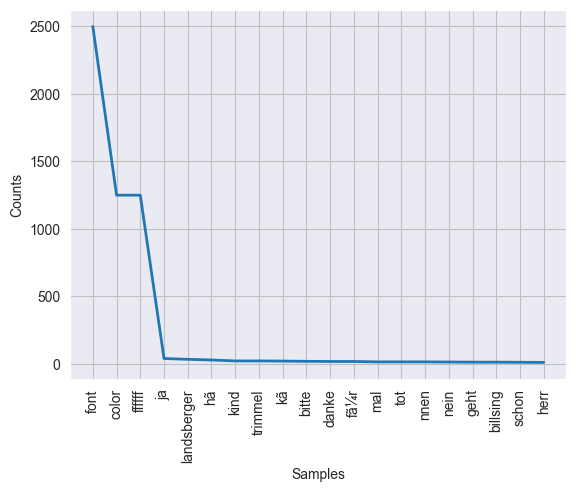

<Axes: xlabel='Samples', ylabel='Counts'>

In [21]:
# plot the word frequency
sns.set_style('darkgrid')
freq_words = nltk.FreqDist(words)
freq_words.plot(20)

In [47]:
# TODO

# remove font color tags
# everything from < to > 
# <font color=#ffffff>(Motor wird angelassen)</font>

# # combine rows until period or end character reached
# not creating a new df